# Humanoid Model Predictive Control

The following notebook is part of the final project from the course of *<a href="https://scaron.info/robotics-mva/">Robotics</a>* from the master *Mathématiques, Vision et Apprendissage (MVA)* - *ENS Paris Saclay* - France


# Reproduce the formulation and resolution of Model Predictive Control as a QP problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qpsolvers
from pinocchio import SE3

from scripts.humanoid_mpc import MPCParams, feet, foot, MPCForce
from utils.meshcat_viewer_wrapper import MeshcatVisualizer
import time

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

## General Problem

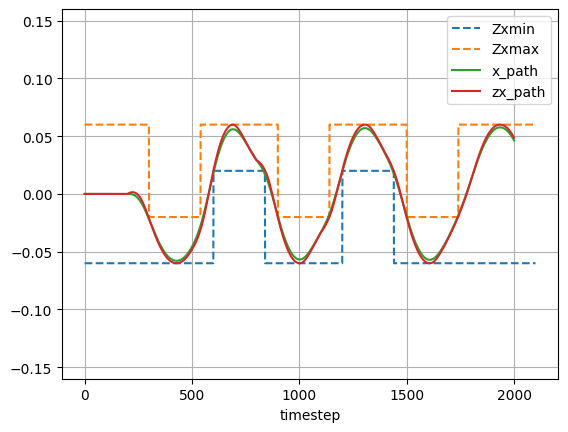

In [39]:
T = 0.01
g = 9.87
h_CoM = 0.44
N = 100
width = 0.04
length = 0.04
robot_feet = feet(spread=0.05, length=length, width=width, right=foot(-width, 0), left=foot(+width, 0))
 

mpc = MPCParams(T, N, h_CoM, g, robot_feet, duration=21, step_duration=3)

Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

plt.plot(Zxmin,'--', label= 'Zxmin')
plt.plot(Zxmax,'--', label="Zxmax")
plt.plot(x_path, label="x_path")
plt.plot(zx_path, label="zx_path")
plt.xlabel('timestep')
plt.ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)

plt.legend()
plt.grid()

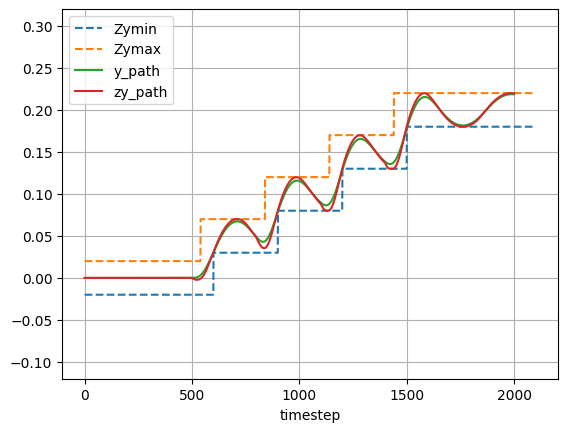

In [23]:
Zymin, Zymax = mpc.Zmin[1], mpc.Zmax[1]
y_path, zy_path, jerks = mpc.solve(Zymin, Zymax, coord="y") 

plt.plot(Zymin,'--', label= 'Zymin')
plt.plot(Zymax,'--', label="Zymax")
plt.plot(y_path, label="y_path")
plt.plot(zy_path, label="zy_path")
plt.xlabel('timestep')
plt.ylim(min(Zymin)-0.1, max(Zymax)+0.1)

plt.legend()
plt.grid()

## Applying force

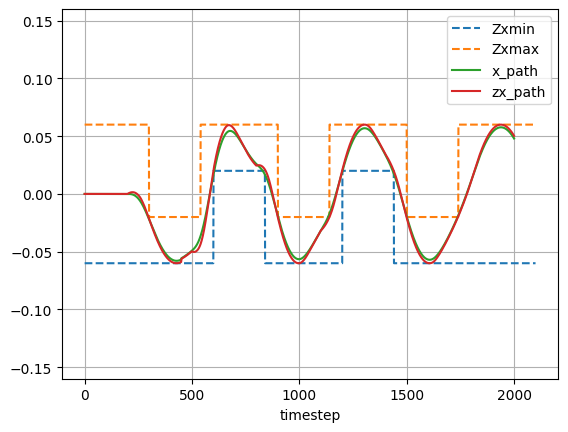

In [34]:
mpc = MPCForce(T, N, h_CoM, g, robot_feet, duration=21, step_duration=3, force=0.1)

Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x', force_k=450)

plt.plot(Zxmin,'--', label= 'Zxmin')
plt.plot(Zxmax,'--', label="Zxmax")
plt.plot(x_path, label="x_path")
plt.plot(zx_path, label="zx_path")
plt.xlabel('timestep')
plt.ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)

plt.legend()
plt.grid()

## Comparing Different solvers:


In [37]:
# T = 0.01
# g = 9.87
# h_CoM = 0.44
# N = 100

# robot_feet = feet(spread=0.05, length=0.04, width=0.04, right=foot(-0.04, 0), left=foot(+0.04, 0))
 
# for solver in qpsolvers.available_solvers[::-1]:
#     mpc = MPCParams(T, N, h_CoM, g, robot_feet, duration=21, step_duration=3)

#     Zxmin, Zxmax = mpc.Zmin[0], mpc.Zmax[0]
#     x_path, zx_path, jerks = mpc.solve(Zxmin, Zxmax, coord='x')

#     plt.plot(Zxmin,'--', label= 'Zxmin')
#     plt.plot(Zxmax,'--', label="Zxmax")
#     plt.plot(x_path, label="x_path")
#     plt.plot(zx_path, label="zx_path")
#     plt.xlabel('timestep')
#     plt.title(solver)
#     plt.ylim(min(Zxmin)-0.1, max(Zxmax)+0.1)

#     plt.legend()
#     plt.grid()
#     plt.show()

## Sphere Visualization

In [1]:
viz = MeshcatVisualizer()
viz.addSphere('CoM', radius=.01, color='red')
viz.addSphere('CoP', radius=.01, color='green')

In [283]:
for x_CoM, zx_CoP, y_CoM, zy_CoP in zip(x_path, zx_path, y_path, zy_path):
    displacement_CoM = SE3(np.eye(3), np.array([x_CoM, y_CoM, h_CoM]))
    displacement_CoP = SE3(np.eye(3), np.array([zx_CoP, zy_CoP, 0]))
    viz.applyConfiguration('CoM', displacement_CoM)
    viz.applyConfiguration('CoP', displacement_CoP)
    time.sleep(T)

## Steps Visualization

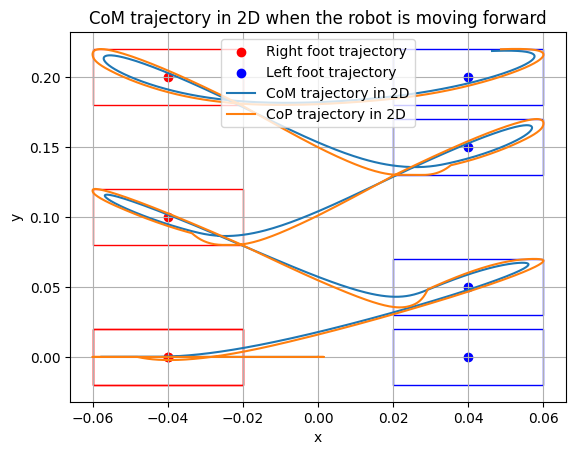

In [55]:
from matplotlib.patches import Rectangle

feet_tracker = mpc.feet_tracker
left_foot = mpc.left_trajectory
right_foot = mpc.right_trajectory

zy__right_path = [pos[1] for pos in right_foot]
zy__left_path = [pos[1] for pos in left_foot]

zx__right_path = [pos[0] for pos in right_foot]
zx__left_path = [pos[0] for pos in left_foot]


plt.scatter(zx__right_path, zy__right_path, c="r", label="Right foot trajectory")
plt.scatter(zx__left_path, zy__left_path, c="b", label="Left foot trajectory")
plt.plot(x_path, y_path, label="CoM trajectory in 2D")
plt.plot(zx_path, zy_path, label="CoP trajectory in 2D")
# draw a bounding box of each zx__right_path and zx__left_path pair
for i in range(len(zx__right_path)):
    rect = Rectangle((zx__right_path[i]-width/2, zy__right_path[i]-length/2), width, length, fill=False, color="r")
    plt.gca().add_patch(rect)
    rect = Rectangle((zx__left_path[i]-width/2, zy__left_path[i]-length/2), width, length, fill=False, color="b")
    plt.gca().add_patch(rect)
plt.xlabel('x')
plt.ylabel('y')
plt.title("CoM trajectory in 2D when the robot is moving forward")
# legend in the top middle
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center')

plt.grid()
plt.show()